In [1]:
from Header import *
from Functions import *
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
df = pd.read_pickle("training_df.pkl")

In [3]:
df.head()

,ID,Sentence,Positive,Negative,Neutral,Label,PositiveLabel,NegativeLabel
0,253,"In this informed consent application, there ar...",1,0,0,Positive,Positive,NotNegative
1,53,The results of study 084-09 with 100mg formula...,1,0,0,Positive,Positive,NotNegative
2,250,The main side effects that have been observed ...,0,0,1,Neutral,NotPositive,NotNegative
3,262,"Compared to SOF/VEL and placebo, there were si...",1,0,0,Positive,Positive,NotNegative
4,239,"Study TRIPLE 5, triple therapy with BDP/FF/GB ...",1,0,0,Positive,Positive,NotNegative


# Positive model

## First implementation

### Encode y-labels

In [4]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(df.PositiveLabel)

### Vectorize x

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

In [6]:
vectorizer = CountVectorizer(binary=True, strip_accents='unicode', lowercase=True,
                             stop_words=None, token_pattern='[a-z]{3,}', max_df=0.3)
# tokens only with 3 or more characters
X = vectorizer.fit_transform(df['Sentence']).toarray()

In [7]:
vectorizer.stop_words_

{'and', 'the', 'with'}

In [8]:
vectorizer.vocabulary_

{'this': 1110,
 'informed': 554,
 'consent': 228,
 'application': 78,
 'there': 1105,
 'are': 86,
 'new': 732,
 'issues': 585,
 'related': 921,
 'clinical': 180,
 'data': 270,
 'results': 945,
 'study': 1052,
 'formulation': 436,
 'can': 146,
 'extrapolated': 402,
 'other': 768,
 'strengths': 1046,
 'according': 11,
 'conditions': 222,
 'guidelines': 475,
 'main': 650,
 'side': 1006,
 'effects': 340,
 'that': 1100,
 'have': 482,
 'been': 114,
 'observed': 753,
 'chf': 165,
 'associated': 94,
 'known': 595,
 'ics': 509,
 'lama': 603,
 'laba': 597,
 'compared': 202,
 'sof': 1029,
 'vel': 1163,
 'placebo': 805,
 'were': 1188,
 'similar': 1012,
 'rates': 890,
 'aes': 42,
 'overall': 770,
 'only': 760,
 'notable': 741,
 'difference': 300,
 'being': 116,
 'increased': 533,
 'mild': 687,
 'grade': 467,
 'nausea': 723,
 'diarrhoea': 296,
 'triple': 1139,
 'therapy': 1104,
 'bdp': 113,
 'had': 476,
 'statistically': 1043,
 'significant': 1009,
 'clinically': 181,
 'relevant': 924,
 'superior': 

In [9]:
np.shape(X)

### Train model and evaluate

#### regularization parameter

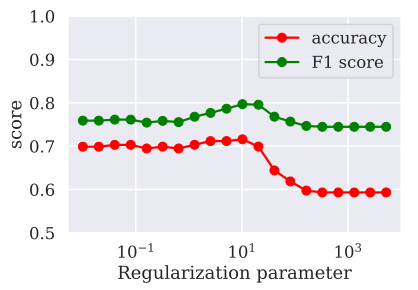

In [10]:
n_cv = 5 # Number of cross validations
lambdas = 0.01*2**np.arange(20)

plotRegulParam(lambdas, X, y, n_cv=n_cv)
#plotRegulParam(lambdas, X, y, n_cv=n_cv, filename="regular1.pdf")

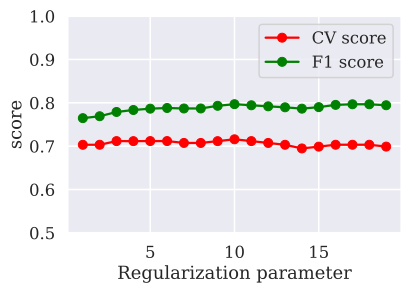

In [11]:
lambdas = np.arange(1,20)

plotRegulParam(lambdas, X, y, n_cv=n_cv, logScale=False)

#### Learning curves

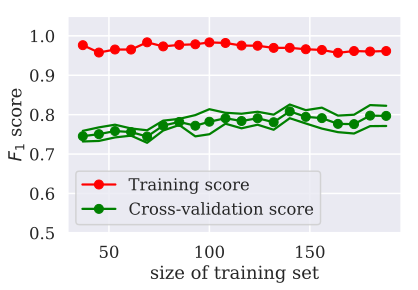

In [12]:
lamb = 10.

plotLearning(lamb, X, y, n_cv)
#plotLearning(lamb, X, y, n_cv, filename="learning1.pdf")

The variance is high.
Because the variance is high, it would help to get more data.
The regularization we optimized.
One more possibility is to decrease the number of features.

In [13]:
kFoldSummary(encoder, lamb, X, y, n_cv, 1)

accuracy score: 0.695 +/- 0.065
f1_score: 0.782 +/- 0.050
precision for index 1: 0.681 +/- 0.091
recall for index 1: 0.934 +/- 0.058
confusion matrix mean
['NotPositive' 'Positive']
[[0.14388298 0.26320922]
 [0.04228723 0.55062057]]
confusion matrix std:
 [[0.04255652 0.08966111]
 [0.0402326  0.052693  ]]

Predicted label on x-axis, True label on y-axis

Ideal would be
0.407   0
0       0.593


## Less features by decreasing the number of words

In [14]:
import spacy

In [15]:
nlp = spacy.load("en_core_web_sm")

In [16]:
def lemmatize(text):
    with nlp.disable_pipes("tagger", "parser"):
        document = nlp(text)
        lemma = [w.lemma_.lower() for w in document]
        return lemma

df['lemmas'] = df['Sentence'].apply(lemmatize)

In [17]:
df.iloc[0,1]

'In this informed consent application, there are no new issues related to the clinical data. '

In [18]:
df.lemmas[0]

['in',
 'this',
 'inform',
 'consent',
 'application',
 ',',
 'there',
 'be',
 'no',
 'new',
 'issue',
 'relate',
 'to',
 'the',
 'clinical',
 'datum',
 '.']

In [19]:
from spacy.lang.en.stop_words import STOP_WORDS

def removeStopWords(lemmas):
    filtered_sentence =[] 
    for word in lemmas:
        if not word in STOP_WORDS:
            filtered_sentence.append(word) 
    return " ".join(filtered_sentence)

df['noStop'] = df['lemmas'].apply(removeStopWords)

In [20]:
df.noStop[0]

'inform consent application , new issue relate clinical datum .'

In [21]:
def prepare_vector(sentences, labels):
    # X
    lemmas = map(lemmatize, sentences)
    noStop = map(removeStopWords, lemmas)
    vectorizer = CountVectorizer(binary=True, strip_accents='unicode', lowercase=True,
                             stop_words=None, token_pattern='[a-z]{3,}', max_df=0.3)
    # tokens only with 3 or more characters and no numbers
    X = vectorizer.fit_transform(noStop).toarray()
    
    # y
    encoder = LabelEncoder()
    y = encoder.fit_transform(labels)
    
    return X, y, vectorizer, encoder


In [22]:
X, y, vectorizer, encoder = prepare_vector(df.Sentence, df.PositiveLabel)

In [23]:
np.shape(X)

Reduced the number of features by 25 %

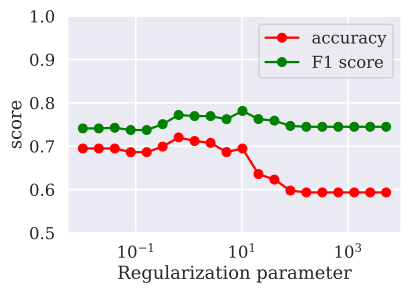

In [24]:
n_cv = 5 # Number of cross validations
lambdas = 0.01*2**np.arange(20)

plotRegulParam(lambdas, X, y, n_cv=n_cv)

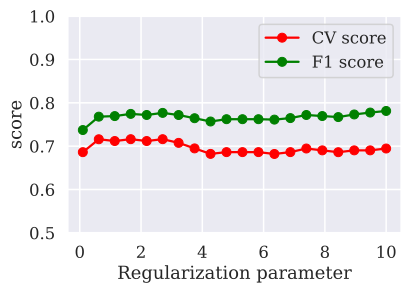

In [25]:
lambdas = np.linspace(0.1,10,20)

plotRegulParam(lambdas, X, y, n_cv=n_cv, logScale=False)

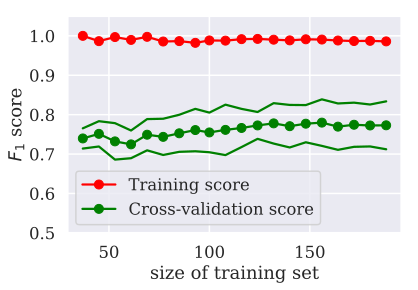

In [26]:
lamb = 3

plotLearning(lamb, X, y, n_cv)

In [27]:
kFoldSummary(encoder, lamb, X, y, n_cv, 1)

accuracy score: 0.720 +/- 0.076
f1_score: 0.783 +/- 0.070
precision for index 1: 0.720 +/- 0.108
recall for index 1: 0.873 +/- 0.064
confusion matrix mean
['NotPositive' 'Positive']
[[0.20328014 0.20381206]
 [0.07606383 0.51684397]]
confusion matrix std:
 [[0.02790456 0.08304254]
 [0.0387824  0.07352065]]

Predicted label on x-axis, True label on y-axis

Ideal would be
0.407   0
0       0.593


## Less features by selecting words automatically

In [28]:
from sklearn.feature_selection import RFECV

maxent = linear_model.LogisticRegression(penalty='l2', C=10, solver='liblinear')
selector = RFECV(maxent, step=1, cv=n_cv, scoring='f1', n_jobs=4,
                                        min_features_to_select=25)
selector = selector.fit(X, y)

In [29]:
print("Optimal number of features : %d" % selector.n_features_)
print("Optimal CV score: %f " % selector.grid_scores_.max())

Optimal number of features : 414
Optimal CV score: 0.756772 


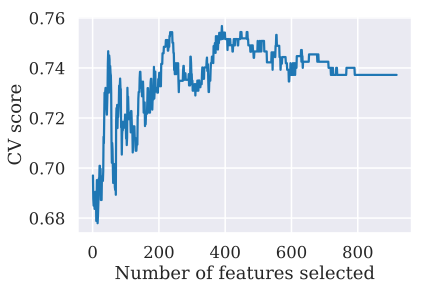

In [30]:
plt.xlabel("Number of features selected")
plt.ylabel("CV score")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()

In [31]:
vocabulary = vectorizer.inverse_transform(selector.support_)[0].tolist()

In [32]:
vectorizerVoc = CountVectorizer(binary=True, strip_accents='unicode', lowercase=True,
                             vocabulary=vocabulary)
# tokens only with 3 or more characters
X = vectorizerVoc.fit_transform(df['noStop']).toarray()

In [33]:
np.shape(X)

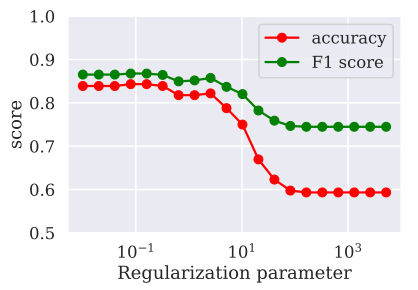

In [34]:
lambdas = 0.01*2**np.arange(20)

plotRegulParam(lambdas, X, y, n_cv=n_cv)

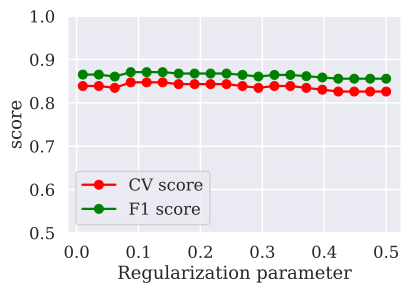

In [35]:
lambdas = np.linspace(0.01,0.5,20)

plotRegulParam(lambdas, X, y, n_cv=n_cv, logScale=False)

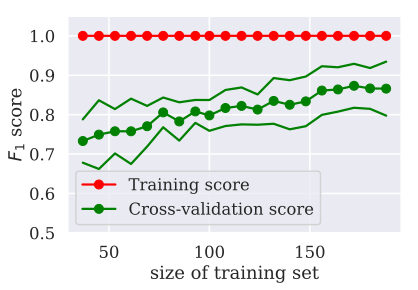

In [36]:
lamb = 0.1

plotLearning(lamb, X, y, n_cv)

In [37]:
kFoldSummary(encoder, lamb, X, y, n_cv, 1)

accuracy score: 0.852 +/- 0.054
f1_score: 0.876 +/- 0.052
precision for index 1: 0.848 +/- 0.096
recall for index 1: 0.915 +/- 0.048
confusion matrix mean
['NotPositive' 'Positive']
[[0.30930851 0.09778369]
 [0.05062057 0.54228723]]
confusion matrix std:
 [[0.04363324 0.0626489 ]
 [0.03107696 0.0795404 ]]

Predicted label on x-axis, True label on y-axis

Ideal would be
0.407   0
0       0.593


## TFIDF
Term frequency (TF) and inverse document frequency (IDF) instead of bag of words (CountVectorizer)

In [38]:
X, y, vectorizer, encoder = prepare_vector(df.Sentence, df.PositiveLabel)

In [39]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer()
X = tfidf.fit_transform(X)

In [40]:
np.shape(X)

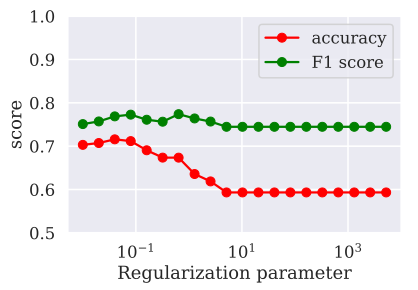

In [41]:
lambdas = 0.01*2**np.arange(20)

plotRegulParam(lambdas, X, y, n_cv=n_cv)

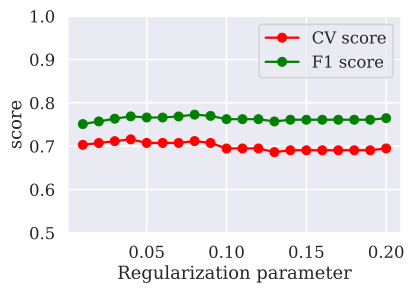

In [42]:
lambdas = np.linspace(0.01,0.2,20)

plotRegulParam(lambdas, X, y, n_cv=n_cv, logScale=False)

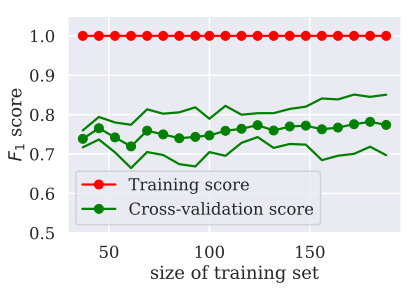

In [43]:
lamb = 0.08

plotLearning(lamb, X, y, n_cv)

In [44]:
kFoldSummary(encoder, lamb, X, y, n_cv, 1)

accuracy score: 0.741 +/- 0.100
f1_score: 0.797 +/- 0.081
precision for index 1: 0.758 +/- 0.141
recall for index 1: 0.864 +/- 0.089
confusion matrix mean
['NotPositive' 'Positive']
[[0.23280142 0.17429078]
 [0.08466312 0.50824468]]
confusion matrix std:
 [[0.05239234 0.1131139 ]
 [0.05850124 0.05455954]]

Predicted label on x-axis, True label on y-axis

Ideal would be
0.407   0
0       0.593


## TFIDF with automatic feature selection

In [45]:
X, y, vectorizer, encoder = prepare_vector(df.Sentence, df.PositiveLabel)
tfidf = TfidfTransformer()
X = tfidf.fit_transform(X)

In [46]:
maxent = linear_model.LogisticRegression(penalty='l2', C=10, solver='liblinear')
selector = RFECV(maxent, step=1, cv=n_cv, scoring='f1', n_jobs=4,
                                        min_features_to_select=25)
selector = selector.fit(X, y)

In [47]:
print("Optimal number of features : %d" % selector.n_features_)
print("Optimal CV score: %f " % selector.grid_scores_.max())

Optimal number of features : 651
Optimal CV score: 0.772221 


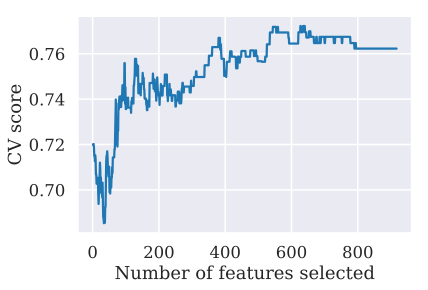

In [48]:
plt.xlabel("Number of features selected")
plt.ylabel("CV score")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()

In [49]:
vocabulary = vectorizer.inverse_transform(selector.support_)[0].tolist()

vectorizerVoc = CountVectorizer(binary=True, strip_accents='unicode', lowercase=True,
                             vocabulary=vocabulary)
# tokens only with 3 or more characters
X = vectorizerVoc.fit_transform(df['noStop']).toarray()

tfidf = TfidfTransformer()
X = tfidf.fit_transform(X)

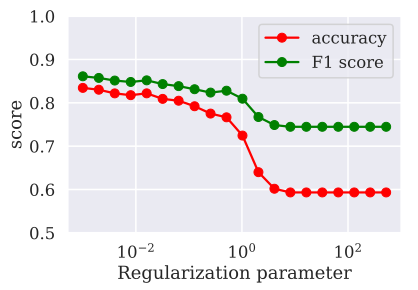

In [50]:
lambdas = 0.001*2**np.arange(20)

plotRegulParam(lambdas, X, y, n_cv=n_cv)

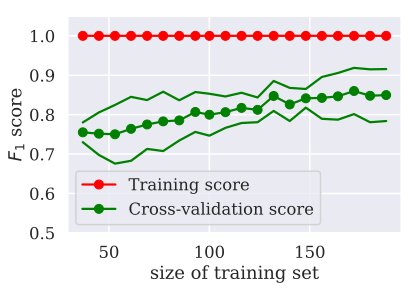

In [51]:
lamb = 0.0001

plotLearning(lamb, X, y, n_cv)

In [52]:
kFoldSummary(encoder, lamb, X, y, n_cv, 1)

accuracy score: 0.826 +/- 0.068
f1_score: 0.859 +/- 0.057
precision for index 1: 0.833 +/- 0.128
recall for index 1: 0.905 +/- 0.040
confusion matrix mean
['NotPositive' 'Positive']
[[0.29219858 0.11489362]
 [0.05913121 0.5337766 ]]
confusion matrix std:
 [[0.04797598 0.09185972]
 [0.0306122  0.05300232]]

Predicted label on x-axis, True label on y-axis

Ideal would be
0.407   0
0       0.593


# Negative model

In [53]:
X, y, vectorizer, encoder = prepare_vector(df.Sentence, df.NegativeLabel)

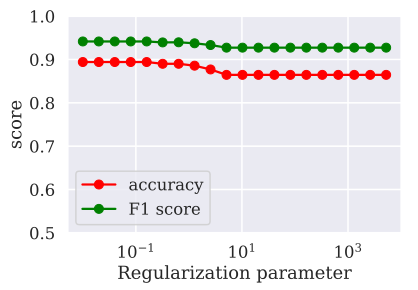

In [54]:
n_cv = 5 # Number of cross validations
lambdas = 0.01*2**np.arange(20)


plotRegulParam(lambdas, X, y, n_cv)

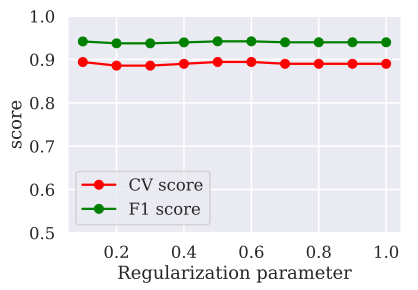

In [55]:
lambdas = np.linspace(0.1,1,10)

plotRegulParam(lambdas, X, y, n_cv, False)

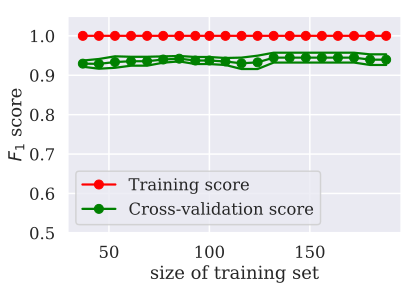

In [56]:
lamb = 0.5

plotLearning(lamb, X, y, n_cv)

In [57]:
kFoldSummary(encoder, lamb, X, y, n_cv)

accuracy score: 0.886 +/- 0.017
f1_score: 0.937 +/- 0.010
precision for index 0: 0.800 +/- 0.400
recall for index 0: 0.186 +/- 0.104
confusion matrix mean
['Negative' 'NotNegative']
[[0.02969858 0.10585106]
 [0.00851064 0.85593972]]
confusion matrix std:
 [[0.01706647 0.03263375]
 [0.01702128 0.03121021]]

Predicted label on x-axis, True label on y-axis

Ideal would be
0.136   0
0       0.864


The recal is a problem.
Maybe, we can optimize for recall

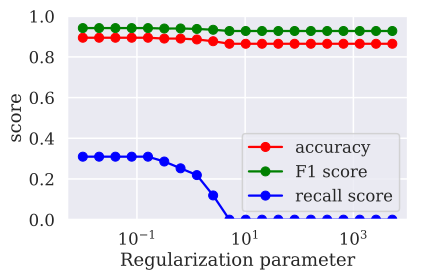

In [58]:
from sklearn.metrics import recall_score

lambdas = 0.01*2**np.arange(20)
cv_scores = np.zeros(len(lambdas))
f1_scores = np.zeros(len(lambdas))
recall_scores = np.zeros(len(lambdas))

def recal_idx0(estimator, X, y):
    return recall_score(y, estimator.predict(X), pos_label=0, average='binary')
def recal_idx1(estimator, X, y):
    return recall_score(y, estimator.predict(X), pos_label=1, average='binary')

for i,l in enumerate(lambdas):
    maxent = linear_model.LogisticRegression(penalty='l2', C=1/l, solver='liblinear')
    cv_scores[i] = np.mean(cross_val_score(maxent, X, y, cv=n_cv, scoring='accuracy'))
    f1_scores[i] = np.mean(cross_val_score(maxent, X, y, cv=n_cv, scoring='f1'))
    recall_scores[i] = np.mean(cross_val_score(maxent, X, y, cv=n_cv, scoring=recal_idx0))  
    

plt.semilogx(lambdas, cv_scores, 'o-', color="r",label="accuracy")
plt.semilogx(lambdas, f1_scores, 'o-', color="g",label="F1 score")
plt.semilogx(lambdas, recall_scores, 'o-', color="b",label="recall score")
plt.ylim([0,1]); plt.legend(); plt.xlabel("Regularization parameter")
plt.ylabel(r"score")
plt.tight_layout(); plt.show()
#plt.savefig("regular2.pdf")

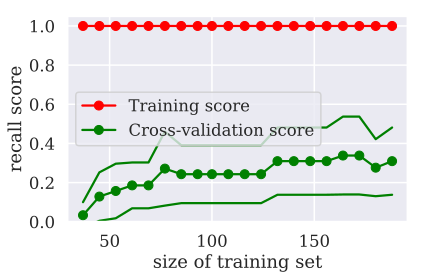

In [59]:
lamb = 0.001
maxent = linear_model.LogisticRegression(penalty='l2', C=1/lamb, solver='liblinear')

n_jobs = 4 # number of jobs
train_sizes = np.linspace(0.2, 1.0, 20) # fraction of training data used
train_sizes, train_scores, test_scores = \
        learning_curve(maxent, X, y, cv=n_cv, n_jobs=n_jobs,
                       train_sizes=train_sizes, scoring=recal_idx0)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
plt.plot(train_sizes, test_scores_mean+test_scores_std, '-', color="g")
plt.plot(train_sizes, test_scores_mean-test_scores_std, '-', color="g")
plt.ylim([0.,1.05]); plt.legend(); plt.xlabel("size of training set")
plt.ylabel("recall score"); #plt.show()
plt.tight_layout(); plt.show()
#plt.savefig("learning2.pdf")

F1 and recall score give no different information

In [60]:
kFoldSummary(encoder, lamb, X, y, n_cv)

accuracy score: 0.890 +/- 0.016
f1_score: 0.939 +/- 0.009
precision for index 0: 0.800 +/- 0.400
recall for index 0: 0.268 +/- 0.148
confusion matrix mean
['Negative' 'NotNegative']
[[0.04228723 0.09326241]
 [0.01702128 0.84742908]]
confusion matrix std:
 [[0.02306941 0.02897404]
 [0.03404255 0.01613475]]

Predicted label on x-axis, True label on y-axis

Ideal would be
0.136   0
0       0.864


### Removing features again

In [61]:
X, y, vectorizer, encoder = prepare_vector(df.Sentence, df.NegativeLabel)
maxent = linear_model.LogisticRegression(penalty='l2', C=10, solver='liblinear')
selector = RFECV(maxent, step=1, cv=3, scoring=recal_idx0, n_jobs=4)
selector = selector.fit(X, y)

In [62]:
print("Optimal number of features : %d" % selector.n_features_)
print("Optimal recall score: %f " % selector.grid_scores_.max())

Optimal number of features : 299
Optimal recall score: 0.281818 


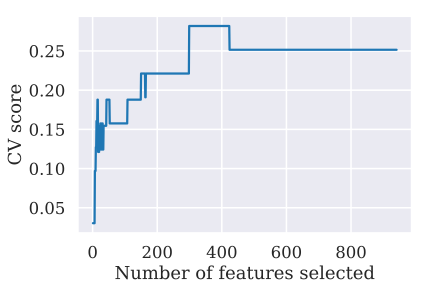

In [63]:
plt.xlabel("Number of features selected")
plt.ylabel("CV score")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()

In [64]:
vocabulary = vectorizer.inverse_transform(selector.support_)[0].tolist()
vectorizerVoc = CountVectorizer(binary=True, strip_accents='unicode', lowercase=True,
                             vocabulary=vocabulary)
# tokens only with 3 or more characters
X = vectorizerVoc.fit_transform(df['noStop']).toarray()

In [65]:
#vectorizerVoc.vocabulary
len(vectorizerVoc.vocabulary)

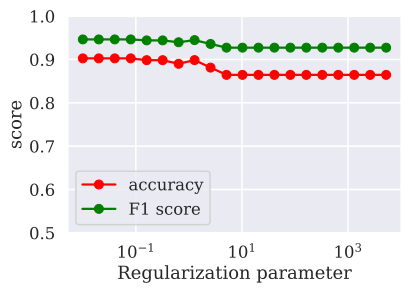

In [66]:
lambdas = 0.01*2**np.arange(20)
plotRegulParam(lambdas, X, y, n_cv)

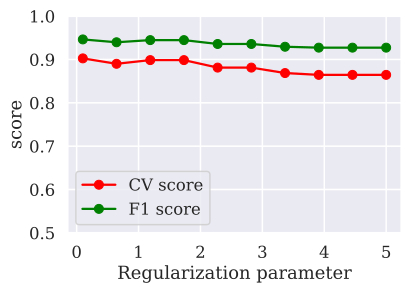

In [67]:
lambdas = np.linspace(0.1,5,10)

plotRegulParam(lambdas, X, y, n_cv, False)

In [68]:
lamb = 1
kFoldSummary(encoder, lamb, X, y, n_cv)

accuracy score: 0.886 +/- 0.017
f1_score: 0.937 +/- 0.010
precision for index 0: 0.800 +/- 0.400
recall for index 0: 0.186 +/- 0.104
confusion matrix mean
['Negative' 'NotNegative']
[[0.02969858 0.10585106]
 [0.00851064 0.85593972]]
confusion matrix std:
 [[0.01706647 0.03263375]
 [0.01702128 0.03121021]]

Predicted label on x-axis, True label on y-axis

Ideal would be
0.136   0
0       0.864


The accuracy and also F1 score are nice but the recall is bad.
We do not even find 20% to 30%.